In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import autokeras as ak
import absl.logging

In [11]:
log_dir='.\\logs'
absl.logging.set_verbosity(absl.logging.ERROR)

In [12]:
dataset = pd.read_csv('./Fog.csv')

In [13]:
print(dataset[(dataset.values == 'X') |(dataset.values == 'V')])

                time  temp dpTemp  RH WDIR    VIZ  Label
5878     2020/9/1-23  28.5   25.6  84    V   8.69      1
8672    2020/12/27-9  17.3   13.4  78    V   5.06      1
11608   2021/4/28-17     X      X   X    X   5.16      1
11608   2021/4/28-17     X      X   X    X   5.16      1
11608   2021/4/28-17     X      X   X    X   5.16      1
...              ...   ...    ...  ..  ...    ...    ...
15782  2021/10/19-15  28.2   17.4  52    X  26.98      1
15825  2021/10/21-10     X      X   X    X  18.15      1
15825  2021/10/21-10     X      X   X    X  18.15      1
15825  2021/10/21-10     X      X   X    X  18.15      1
15825  2021/10/21-10     X      X   X    X  18.15      1

[69 rows x 7 columns]


In [14]:
dataset.drop(dataset.index[dataset[(dataset.values == 'X') | \
    (dataset.values == 'V')].index], inplace=True)
dataset = dataset.drop(['time','Label'],axis=1)
dataset = dataset.astype("float64")
dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19659 entries, 0 to 19679
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    19659 non-null  float64
 1   dpTemp  19659 non-null  float64
 2   RH      19659 non-null  float64
 3   WDIR    19659 non-null  float64
 4   VIZ     19659 non-null  float64
dtypes: float64(5)
memory usage: 921.5 KB


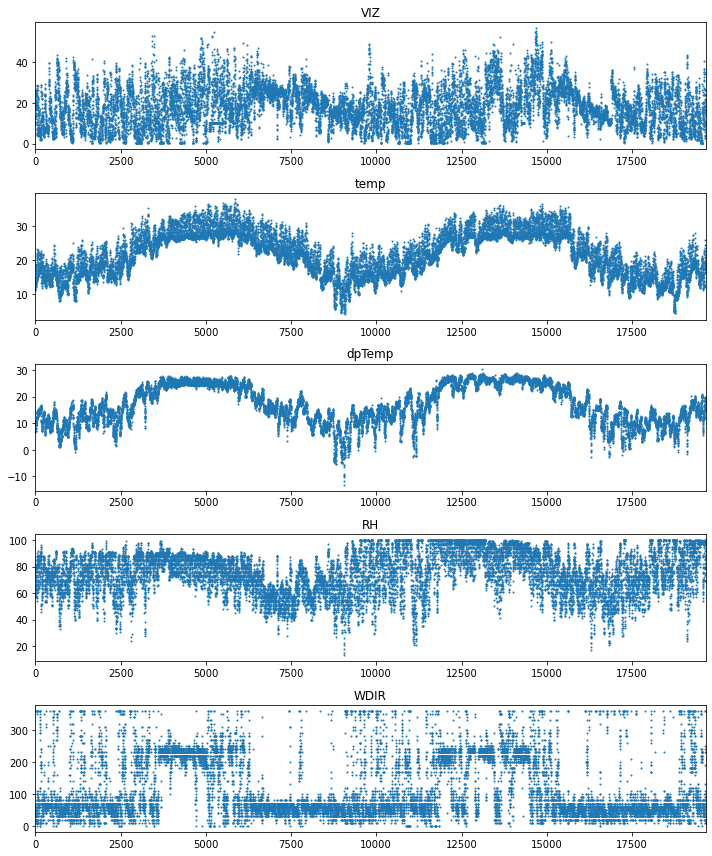

In [15]:
fig = plt.figure(figsize=(10, 12))

names = ('VIZ', 'temp', 'dpTemp', 'RH', 'WDIR')

for i in range(5):
    data = dataset[names[i]]
    ax = fig.add_subplot(5, 1, i + 1)
    plt.scatter(np.arange(data.size), data, s=1)
    ax.set_xlim([0, data.size])
    ax.set_title(names[i])

plt.tight_layout()
plt.show()

In [16]:
split = 0.125

x = dataset.drop(['VIZ'], axis=1)
y = dataset['VIZ']

slice_index = int(y.size * (1 - split))
x_train, x_test = x[:slice_index], x[slice_index:]
y_train, y_test = y[:slice_index], y[slice_index:]

x_train.info()
x_test.info()
print(x_train.shape)
print(x_test.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17201 entries, 0 to 17221
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    17201 non-null  float64
 1   dpTemp  17201 non-null  float64
 2   RH      17201 non-null  float64
 3   WDIR    17201 non-null  float64
dtypes: float64(4)
memory usage: 671.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2458 entries, 17222 to 19679
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    2458 non-null   float64
 1   dpTemp  2458 non-null   float64
 2   RH      2458 non-null   float64
 3   WDIR    2458 non-null   float64
dtypes: float64(4)
memory usage: 96.0 KB
(17201, 4)
(2458, 4)


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
lookback = 24
batch_size = 8

fog = ak.TimeseriesForecaster(
    lookback=lookback, max_trials=100, overwrite=True)

fog.fit(
    x_train, y_train, batch_size=batch_size,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Trial 1 Complete [00h 04m 17s]
val_loss: 88.99483489990234

Best val_loss So Far: 88.99483489990234
Total elapsed time: 00h 04m 17s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
2146/2146 [==============================] - 33s 13ms/step - loss: 175.1595 - mean_squared_error: 175.1595
Epoch 2/10
2146/2146 [==============================] - 30s 14ms/step - loss: 95.9290 - mean_squared_error: 95.9290
Epoch 3/10
2146/2146 [==============================] - 29s 14ms/step - loss: 87.6797 - mean_squared_error: 87.6797
Epoch 4/10
2146/2146 [==============================] - 29s 14ms/step - loss: 82.4334 - mean_squared_error: 82.4334
Epoch 5/10
2146/2146 [==============================] - 30s 14ms/step - loss: 80.6525 - mean_squared_error: 80.6525
Epoch 6/10
2146/2146 [==============================] - 32s 15ms/step - loss: 79.0625 - mean_squared_error: 79.0625
Epoch 7/10
2146/2146 [==============================] - 28s 13ms/step - loss: 76.6387 - mean_squared_error: 76.6387
Epoch 8/10
2146/

INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


In [18]:
predicted= fog.predict(x).flatten()
real = y_test[lookback:]

2455/2455 [==============================] - 12s 5ms/step


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Prediction MSE:', mean_squared_error(real, predicted).round(3))
print('Prediction MAE:', mean_absolute_error(real, predicted).round(3))

Prediction MSE: 68.607
Prediction MAE: 6.946


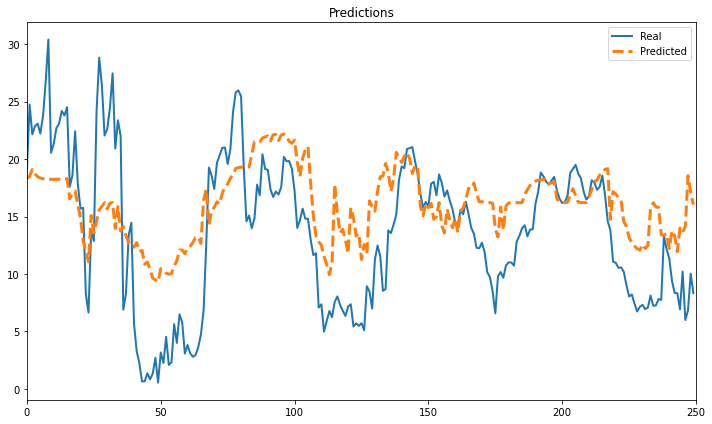

In [20]:
display_size = 250

dx = np.arange(predicted.size)

plt.figure(figsize=(10, 6))
plt.title('Predictions')
plt.plot(dx[:display_size], real[:display_size],
         linewidth=2, label='Real')
plt.plot(dx[:display_size], predicted[:display_size],
         linestyle='--', linewidth=3, label='Predicted')
plt.xlim([0, display_size])
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
model = fog.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 4)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 24, 8)            288       
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 8)                416       
 nal)                                                            
                                                                 
 regression_head_1 (Dense)   (None, 1)                 9         
                                                                 
Total params: 713
Trainable params: 713
Non-trainable params: 0
_________________________________________________________________
